In [1]:
import os
from itertools import chain
import torch
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from pytorch_transformers import *
from xml.dom import minidom
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import spline
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, r2_score, roc_auc_score, auc, roc_curve

In [2]:
num_labels = 3
MODEL_NAME = 'xlm-mlm-tlm-xnli15-1024'
SEQUENCE_LENGTH = 512
TOKENIZER = XLMTokenizer.from_pretrained(MODEL_NAME)
CONFIG = XLMConfig.from_pretrained(MODEL_NAME, num_labels = num_labels)
MODEL = XLMForSequenceClassification.from_pretrained(MODEL_NAME, config = CONFIG)
MODEL.load_state_dict(torch.load('model.torch', map_location='cpu'))

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
def load_semeval(t = 'train', lang = 'en'):
    semeval_keys = {
        'correct': 2,
        'incorrect': 1,
        'contradictory': 0
    }
    
    file = minidom.parse('../../datasets/semeval2013-3way-' + lang + '/' + t + '.xml')
    
    for exercise in file.getElementsByTagName('exercise'):
        
        yield (
            [ reference.firstChild.data for reference in exercise.getElementsByTagName('reference') ],
            [ (answer.firstChild.data, answer.attributes['accuracy'].value) for answer in exercise.getElementsByTagName('answer') ]
        )

In [4]:
MODEL = MODEL.cuda()

In [5]:
semeval_keys = {
    'correct': 2,
    'incorrect': 1,
    'contradictory': 0
}

In [6]:
MODEL.eval()
out = []
ans_i = -1
for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    for r, a in tqdm(list(load_semeval(t, 'de'))):
        for ans, val in a:
            ans_i += 1
            
            for ref in r:
                idx = TOKENIZER.encode(ref, ans, True)
                if len(idx) > SEQUENCE_LENGTH:
                    continue

                mask = [1] * len(idx) + [0] * (SEQUENCE_LENGTH - len(idx))
                idx += [0] * (SEQUENCE_LENGTH - len(idx))
                lang = [ MODEL.config.lang2id['de'] ] * SEQUENCE_LENGTH

                with torch.no_grad():
                    outputs = MODEL(
                        torch.tensor([ idx ]).cuda(),
                        attention_mask = torch.tensor([ mask ]).cuda(),
                        langs = torch.tensor([ lang ]).cuda()
                    )[0][0].cpu()

                preds = outputs.cpu().float().numpy()
                out.append((
                    ans_i,
                    t, 
                    preds[0], 
                    preds[1], 
                    preds[2],
                    semeval_keys[val]
                ))

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [04:53<00:00,  6.43s/it]


In [7]:
outdf = pd.DataFrame(out, columns = [ 
    'answer_id',
    'dataset', 
    'contradictory', 
    'incorrect', 
    'correct',
    'label',
])
outdf.to_csv('eval_de.csv')
outdf.head(2)

answer_id         dataset  contradictory  incorrect   correct  label
0          0  unseen_answers       -8.39654  -6.348339  3.031168      2
1          0  unseen_answers      -11.29652  -5.381188  2.659766      2

In [8]:
summed = outdf.groupby([ 'answer_id', 'dataset', 'label' ]).sum().reset_index()
summed['references'] = outdf.groupby([ 'answer_id', 'dataset', 'label' ]).count().reset_index()['correct']
summed['predicted'] = summed[[ 'contradictory', 'incorrect', 'correct' ]].idxmax(axis = 1).replace(semeval_keys)

summed['contradictory'] = summed['contradictory'] / summed['references']
summed['incorrect'] = summed['incorrect'] / summed['references']
summed['correct'] = summed['correct'] / summed['references']
summed.head(2)

answer_id         dataset  label  contradictory  incorrect    correct  \
0          0  unseen_answers      2      -9.407567  -6.651656   1.997663   
1          1  unseen_answers      1      -9.421174  12.270980 -15.536541   

   references  predicted  
0           4          2  
1           4          1

In [9]:
equal = outdf.copy()
equal['predicted'] = equal[[ 'contradictory', 'incorrect', 'correct' ]].idxmax(axis = 1).replace(semeval_keys)
equal = equal.groupby([ 'answer_id', 'dataset', 'label', 'predicted' ]).count().aggregate('contradictory').unstack().reset_index()
count = outdf.groupby([ 'answer_id', 'dataset', 'label' ]).count().reset_index()['correct']
equal['references'] = count
equal['contradictory'] = equal[0] / count
equal['incorrect'] = equal[1] / count
equal['correct'] = equal[2] / count
equal = equal.drop(columns = [0, 1, 2])
equal = equal.fillna(0)

equal.head(2)

predicted  answer_id         dataset  label  references  contradictory  \
0                  0  unseen_answers      2           4            0.0   
1                  1  unseen_answers      1           4            0.0   

predicted  incorrect  correct  
0               0.25     0.75  
1               1.00     0.00

In [10]:
equal_c = equal.copy()
equal_c['incorrect'] = equal_c['incorrect'] + equal_c['contradictory']
equal_c = equal_c.drop(columns = ['contradictory'])
equal_c['label'] = equal_c['label'].replace({2:1})

equal_c.head(2)

predicted  answer_id         dataset  label  references  incorrect  correct
0                  0  unseen_answers      1           4       0.25     0.75
1                  1  unseen_answers      1           4       1.00     0.00

In [11]:
summed_c = summed.copy()
summed_c['incorrect'] = summed_c['incorrect'] + summed_c['contradictory']
summed_c = summed_c.drop(columns = ['contradictory'])
summed_c['label'] = summed_c['label'].replace({2:1, 1:0})
summed_c['prediction'] = -1 * summed_c['incorrect'] + summed_c['correct']

summed_c.head(2)

answer_id         dataset  label  incorrect    correct  references  \
0          0  unseen_answers      1 -16.059223   1.997663           4   
1          1  unseen_answers      0   2.849806 -15.536541           4   

   predicted  prediction  
0          2   18.056886  
1          1  -18.386348

In [12]:
outdf_c = outdf.copy()
norm_fac = (outdf_c['contradictory'] * outdf_c['contradictory'] + outdf_c['incorrect'] * outdf_c['incorrect'] + outdf_c['correct'] * outdf_c['correct'])**.5
outdf_c['contradictory'] = outdf_c['contradictory'] / norm_fac
outdf_c['incorrect'] = outdf_c['incorrect'] / norm_fac
outdf_c['correct'] = outdf_c['correct'] / norm_fac

outdf_c['incorrect'] = outdf_c['incorrect'] + outdf_c['contradictory']
outdf_c = outdf_c.drop(columns = ['contradictory'])
outdf_c['label'] = outdf_c['label'].replace({2:1, 1:0})
outdf_c['prediction'] = -1 * outdf_c['incorrect'] + outdf_c['correct']


outdf_c.head(2)

answer_id         dataset  incorrect   correct  label  prediction
0          0  unseen_answers  -1.346066  0.276717      1    1.622783
1          0  unseen_answers  -1.303730  0.207919      1    1.511650

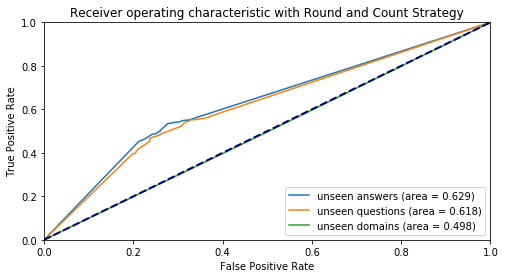

In [13]:
curve_i_ua = roc_curve(
    equal_c[equal_c['dataset'] == 'unseen_answers']['label'], 
    equal_c[equal_c['dataset'] == 'unseen_answers']['correct']
)
curve_i_uq = roc_curve(
    equal_c[equal_c['dataset'] == 'unseen_questions']['label'], 
    equal_c[equal_c['dataset'] == 'unseen_questions']['correct']
)
curve_i_ud = roc_curve(
    equal_c[equal_c['dataset'] == 'unseen_domains']['label'], 
    equal_c[equal_c['dataset'] == 'unseen_domains']['correct']
)

plt.figure(figsize=(8,4))
plt.plot(
    curve_i_ua[0], 
    curve_i_ua[1],
    label='unseen answers (area = %0.03f)' % auc(curve_i_ua[0], curve_i_ua[1])
)
plt.plot(
    curve_i_uq[0], 
    curve_i_uq[1],
    label='unseen questions (area = %.03f)' % auc(curve_i_uq[0], curve_i_uq[1])
)
plt.plot(
    curve_i_ud[0], 
    curve_i_ud[1],
    label='unseen domains (area = %.03f)' % auc(curve_i_ud[0], curve_i_ud[1])
)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with Round and Count Strategy')
plt.legend(loc="lower right")

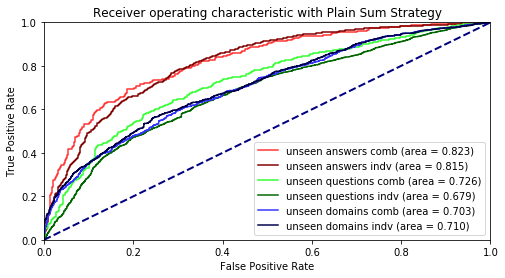

In [14]:
curve_ua = roc_curve(
    summed_c[summed_c['dataset'] == 'unseen_answers']['label'], 
    summed_c[summed_c['dataset'] == 'unseen_answers']['prediction']
)
curve_uq = roc_curve(
    summed_c[summed_c['dataset'] == 'unseen_questions']['label'], 
    summed_c[summed_c['dataset'] == 'unseen_questions']['prediction']
)
curve_ud = roc_curve(
    summed_c[summed_c['dataset'] == 'unseen_domains']['label'], 
    summed_c[summed_c['dataset'] == 'unseen_domains']['prediction']
)

curve_uc_ua = roc_curve(
    outdf_c[outdf_c['dataset'] == 'unseen_answers']['label'], 
    outdf_c[outdf_c['dataset'] == 'unseen_answers']['prediction']
)
curve_uc_uq = roc_curve(
    outdf_c[outdf_c['dataset'] == 'unseen_questions']['label'], 
    outdf_c[outdf_c['dataset'] == 'unseen_questions']['prediction']
)
curve_uc_ud = roc_curve(
    outdf_c[outdf_c['dataset'] == 'unseen_domains']['label'], 
    outdf_c[outdf_c['dataset'] == 'unseen_domains']['prediction']
)

plt.figure(figsize=(8,4))

plt.plot(
    curve_ua[0], 
    curve_ua[1],
    color = (1, .2, .2),
    label = 'unseen answers comb (area = %.03f)' % auc(curve_ua[0], curve_ua[1])
)
plt.plot(
    curve_uc_ua[0], 
    curve_uc_ua[1],
    color = (.5, 0, 0),
    label='unseen answers indv (area = %.03f)' % auc(curve_uc_ua[0], curve_uc_ua[1])
)
plt.plot(
    curve_uq[0], 
    curve_uq[1],
    color = (.2, 1, .2),
    label = 'unseen questions comb (area = %.03f)' % auc(curve_uq[0], curve_uq[1])
)
plt.plot(
    curve_uc_uq[0], 
    curve_uc_uq[1],
    color = (0, .4, 0),
    label='unseen questions indv (area = %.03f)' % auc(curve_uc_uq[0], curve_uc_uq[1])
)
plt.plot(
    curve_ud[0], 
    curve_ud[1],
    color = (.2, .2, 1),
    label = 'unseen domains comb (area = %.03f)' % auc(curve_ud[0], curve_ud[1])
)
plt.plot(
    curve_uc_ud[0], 
    curve_uc_ud[1],
    color = (0, 0, .3),
    label='unseen domains indv (area = %.03f)' % auc(curve_uc_ud[0], curve_uc_ud[1])
)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with Plain Sum Strategy')
plt.legend(loc="lower right")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


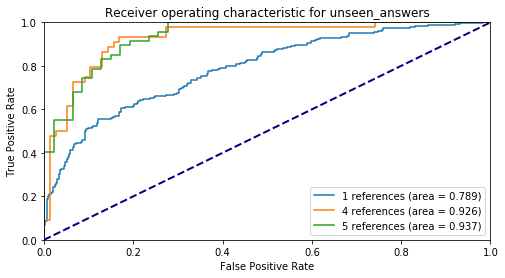

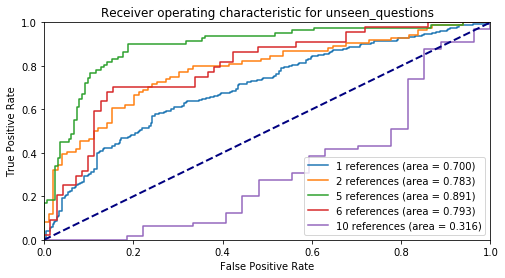

'Plain Sum Stategy by Reference Count'

In [15]:
for t in [ 'unseen_answers', 'unseen_questions' ]:
    reduced = summed_c[summed_c['dataset'] == t].groupby(['references']).count().reset_index()
    plt.figure(figsize=(8,4))
    for count in reduced[reduced['answer_id'] > 90]['references']:
        curve = roc_curve(
            summed_c[summed_c['dataset'] == t][summed_c['references'] == count]['label'], 
            summed_c[summed_c['dataset'] == t][summed_c['references'] == count]['prediction']
        )

        plt.plot(
            curve[0], 
            curve[1],
            label='%d references (area = %.03f)' % (count, auc(curve[0], curve[1]))
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s' % t)
    plt.legend(loc="lower right")
    plt.show()
"Plain Sum Stategy by Reference Count"

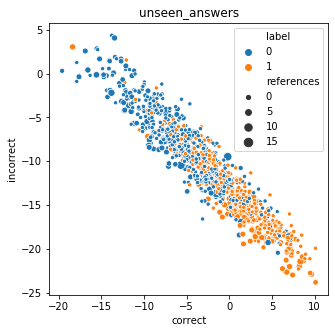

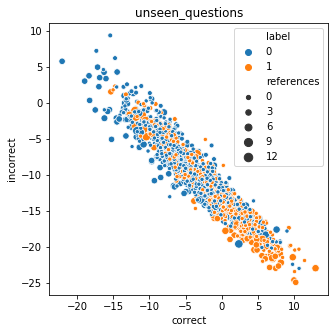

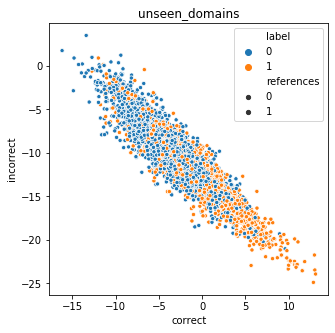

In [16]:
for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    plt.figure(figsize=(5,5))
    sns.scatterplot(x="correct", y="incorrect", hue='label', size='references', data=summed_c[summed_c['dataset'] == t])\
        .title.set_text(t)

unseen_answers with contradictory and incorrect summed


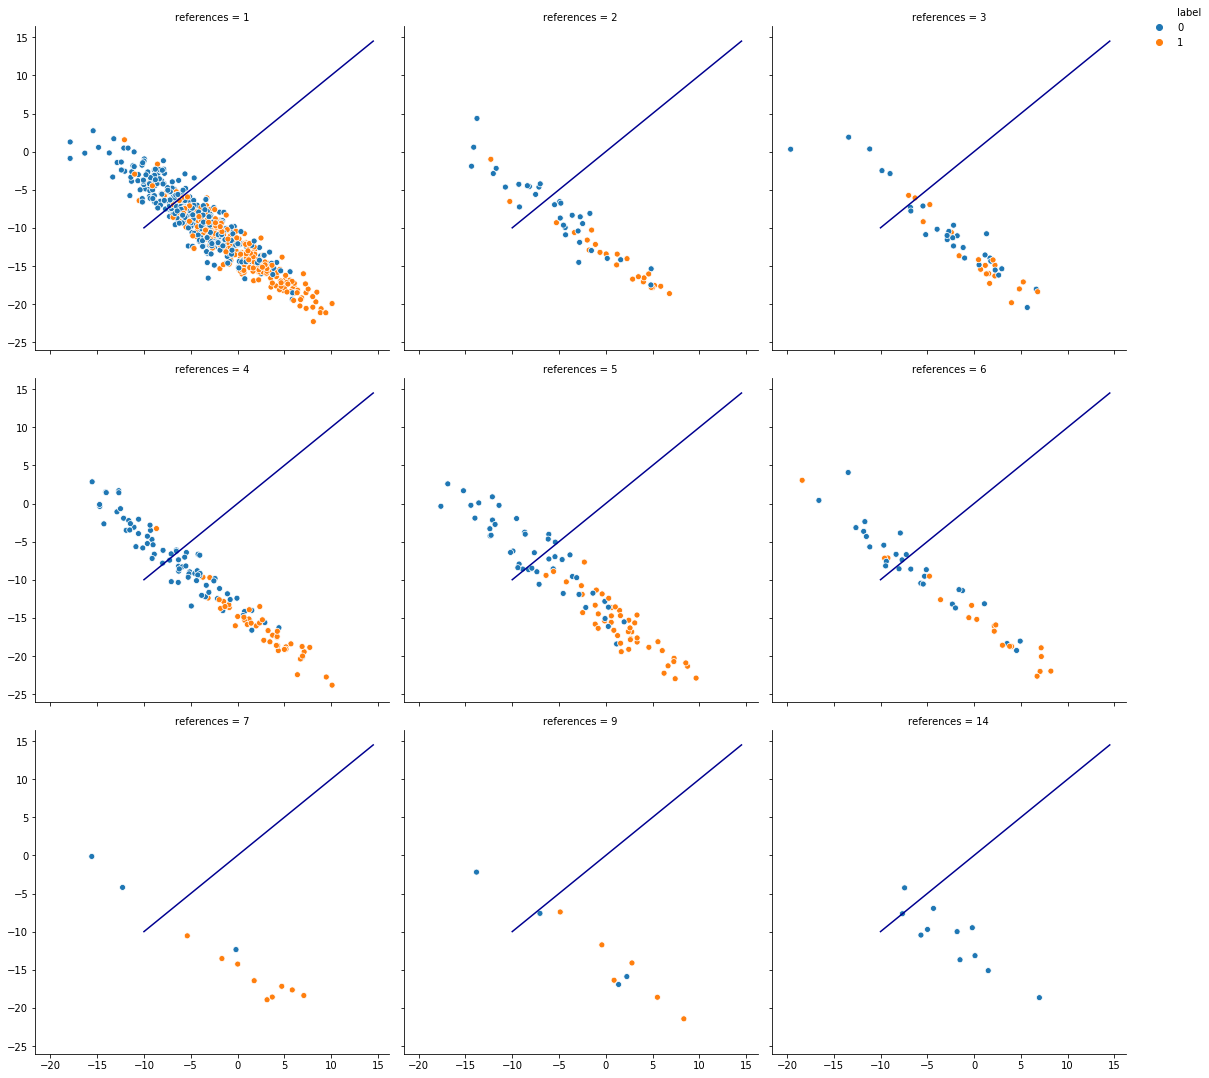

unseen_questions with contradictory and incorrect summed


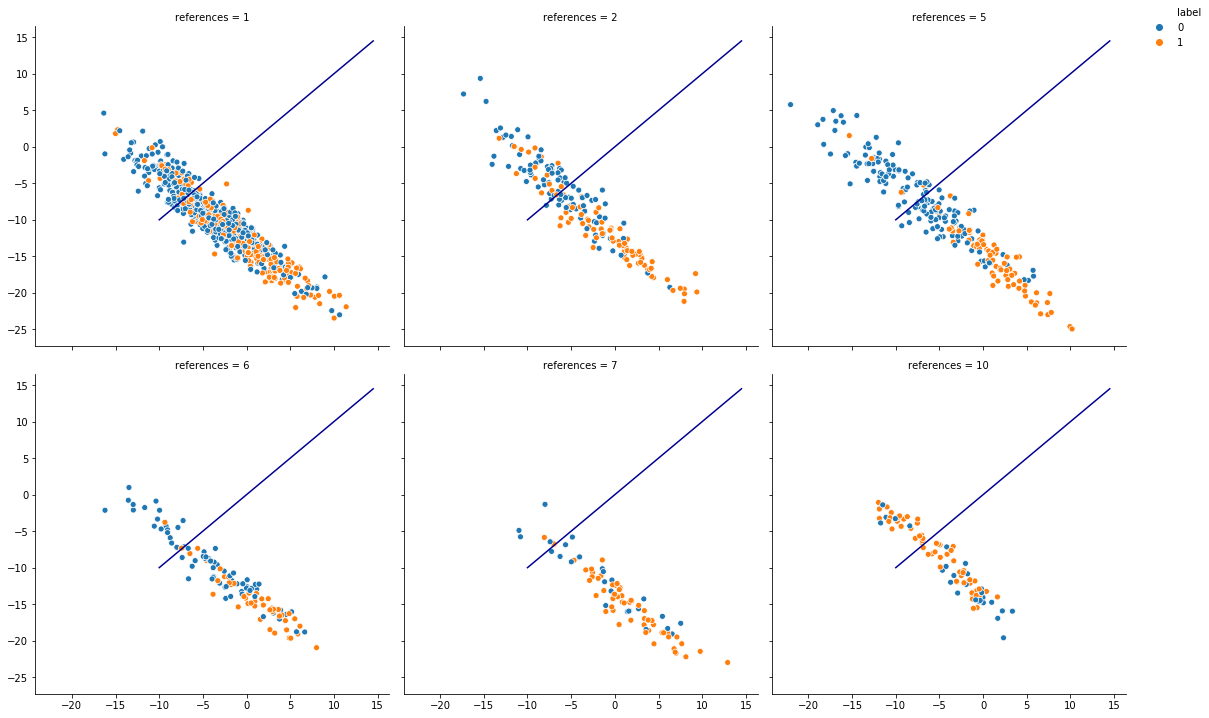

unseen_domains with contradictory and incorrect summed


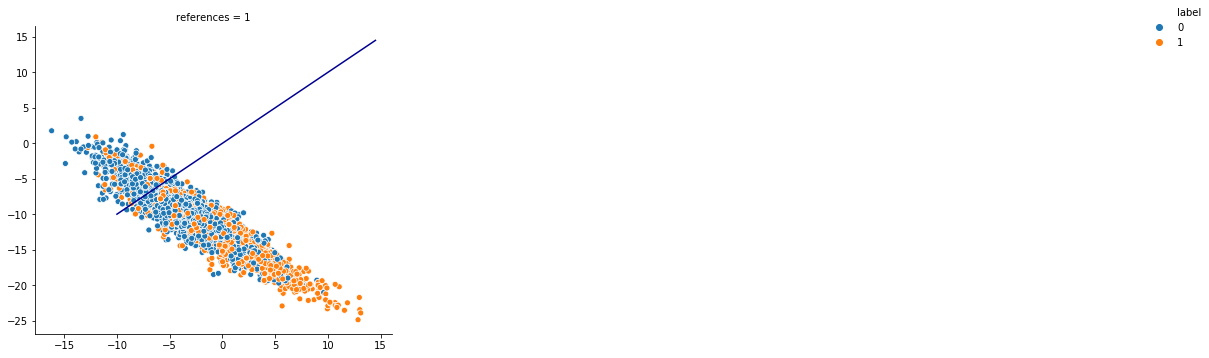

In [17]:
for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    g = sns.relplot(
        x = 'correct',
        y = 'incorrect',
        hue = 'label', 
        col = 'references', 
        data=summed_c[summed_c['dataset'] == t], 
        col_wrap=3
    )
    def const_line(*args, **kwargs):
        x = np.arange(-10, 15, .5)
        y = x
        plt.plot(y, x, C='#000090')

    g.map(const_line)
    leg = g._legend
    leg.set_bbox_to_anchor([1, 1])  # coordinates of lower left of bounding box
    leg._loc = 2  # if required you can set the loc
    
    print('%s with contradictory and incorrect summed' % t)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame i

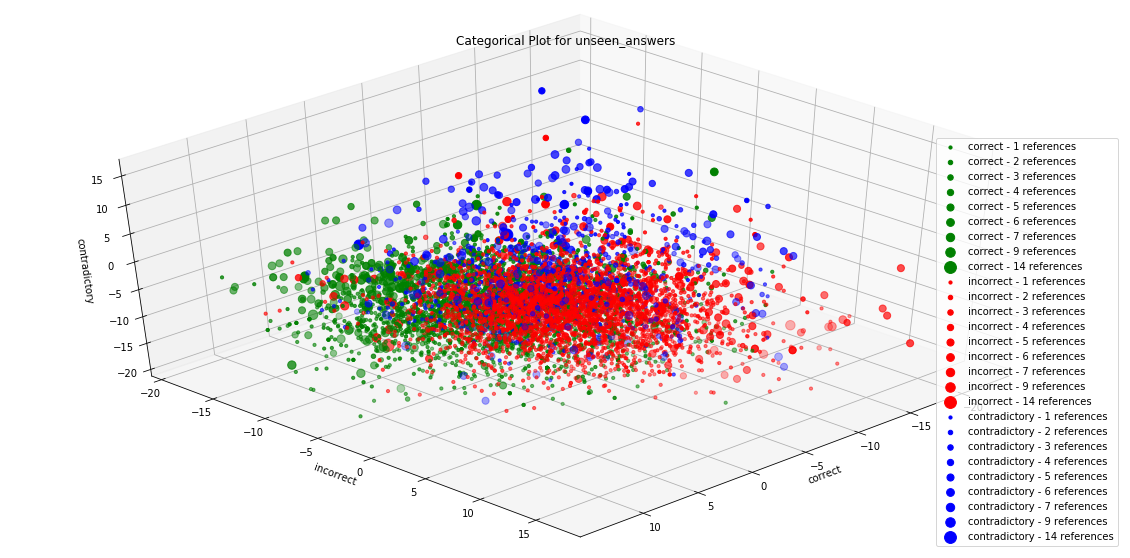

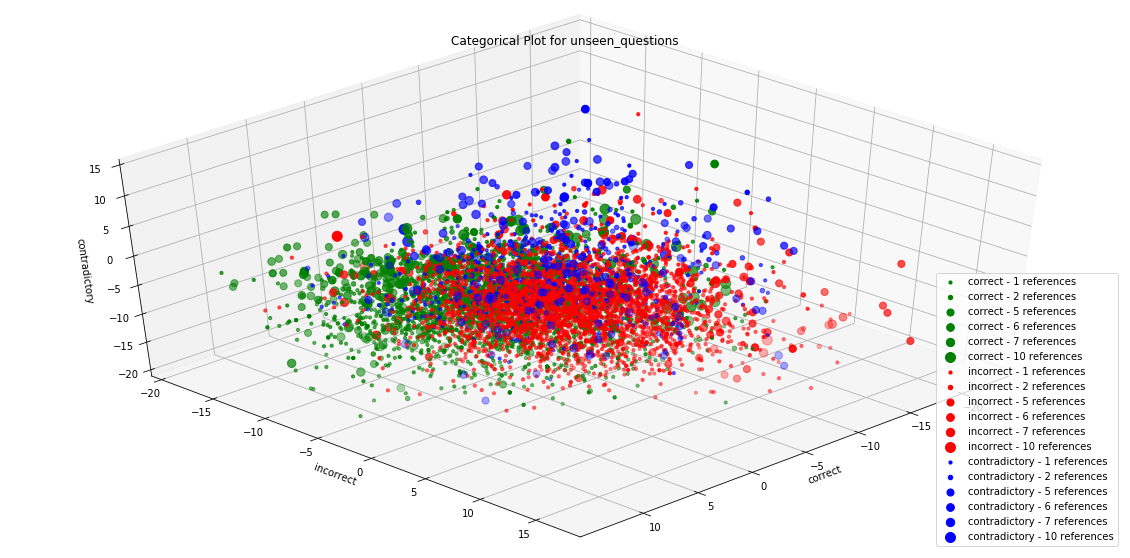

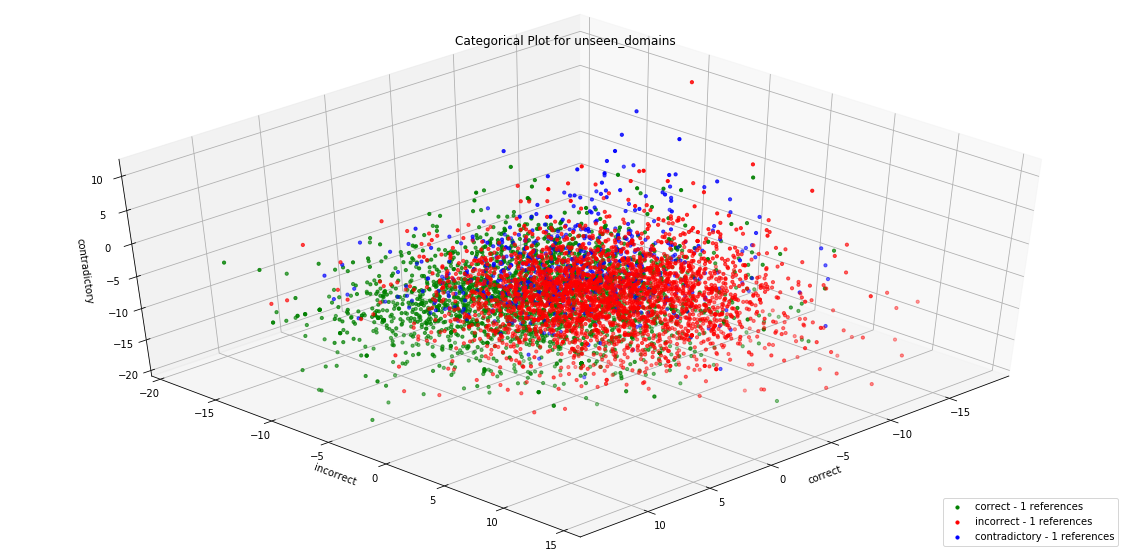

In [18]:
#%matplotlib notebook

for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    reduced = summed_c[summed_c['dataset'] == t].groupby(['references']).count().reset_index()
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    
    for count in reduced['references']:
        ax.scatter(
            summed[summed['label'] == 2][summed['references'] == count]['correct'],
            summed[summed['label'] == 2][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 2][summed['references'] == count]['contradictory'], 
            c = 'green',
            label = 'correct - %d references' % count,
            s = count * 10
        )
    for count in reduced['references']:
        ax.scatter(
            summed[summed['label'] == 1][summed['references'] == count]['correct'],
            summed[summed['label'] == 1][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 1][summed['references'] == count]['contradictory'], 
            c = 'red',
            label = 'incorrect - %d references' % count,
            s = count * 10
        )
    for count in reduced['references']:
        ax.scatter(
            summed[summed['label'] == 0][summed['references'] == count]['correct'],
            summed[summed['label'] == 0][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 0][summed['references'] == count]['contradictory'], 
            c = 'blue',
            label = 'contradictory - %d references' % count,
            s = count * 10
        )

    ax.view_init(45, 45)
    ax.set_xlabel('correct')
    ax.set_ylabel('incorrect')
    ax.set_zlabel('contradictory')
    plt.title('Categorical Plot for %s' % t)
    plt.legend(loc="lower right")
    plt.show()

# TODO Produce Combinations for slides on/off overlay

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\s

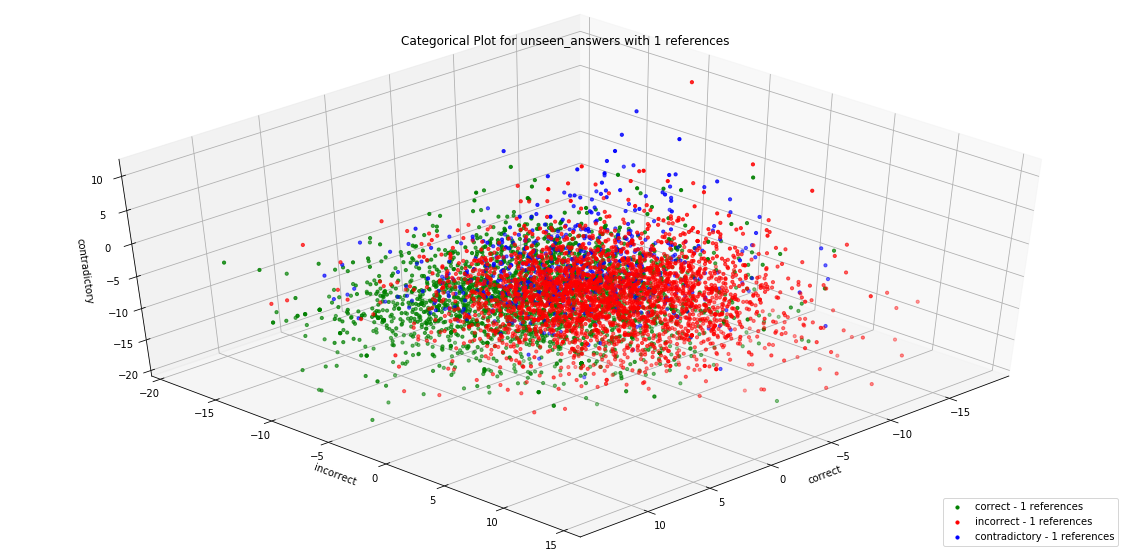

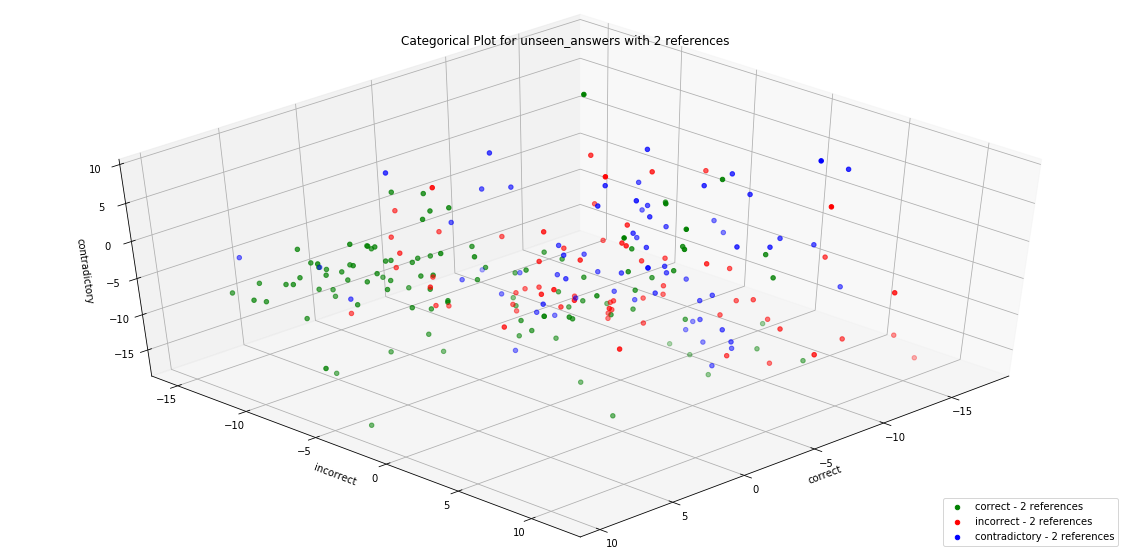

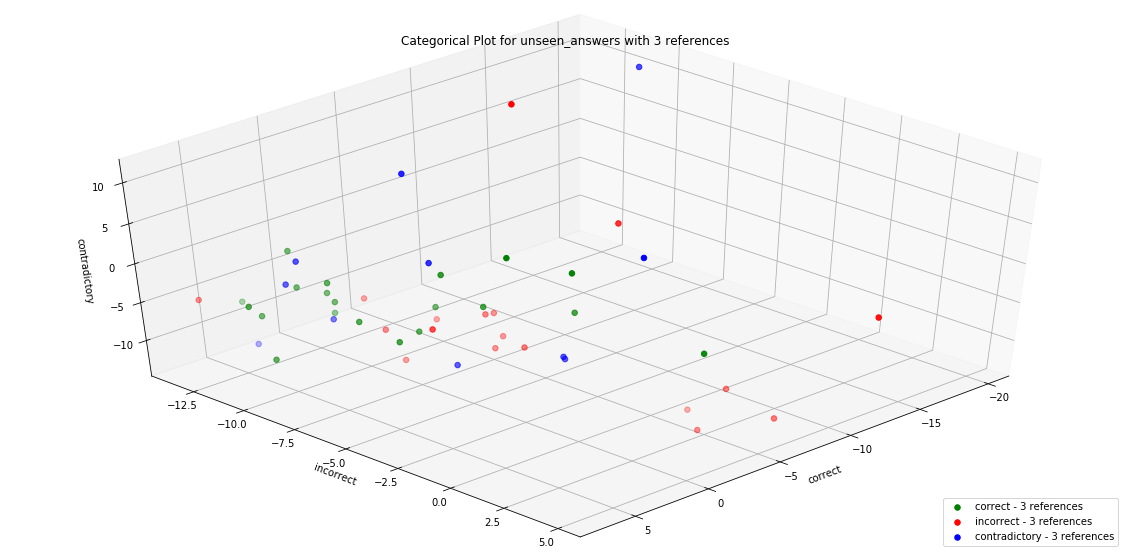

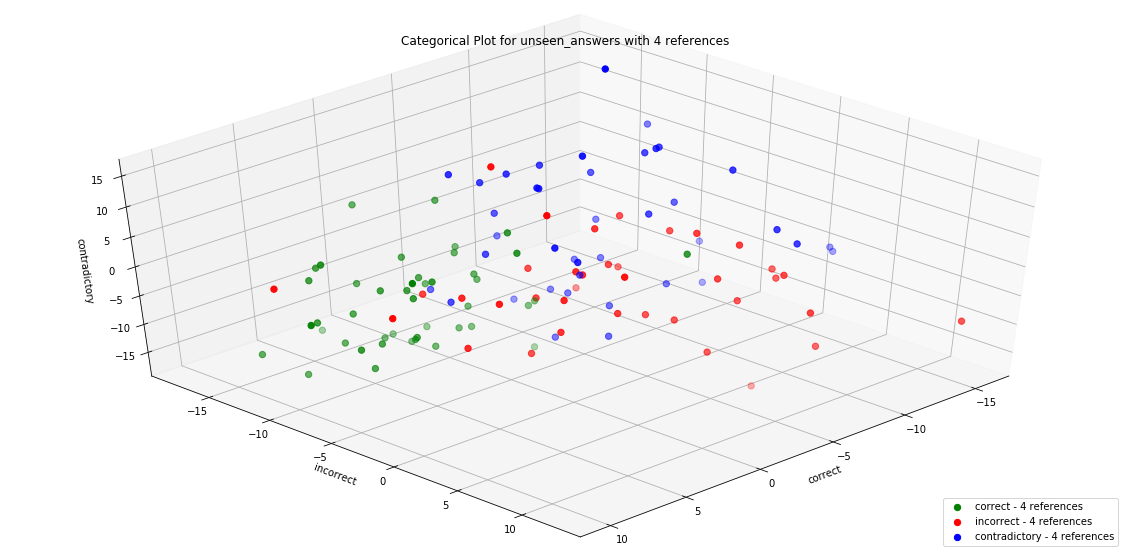

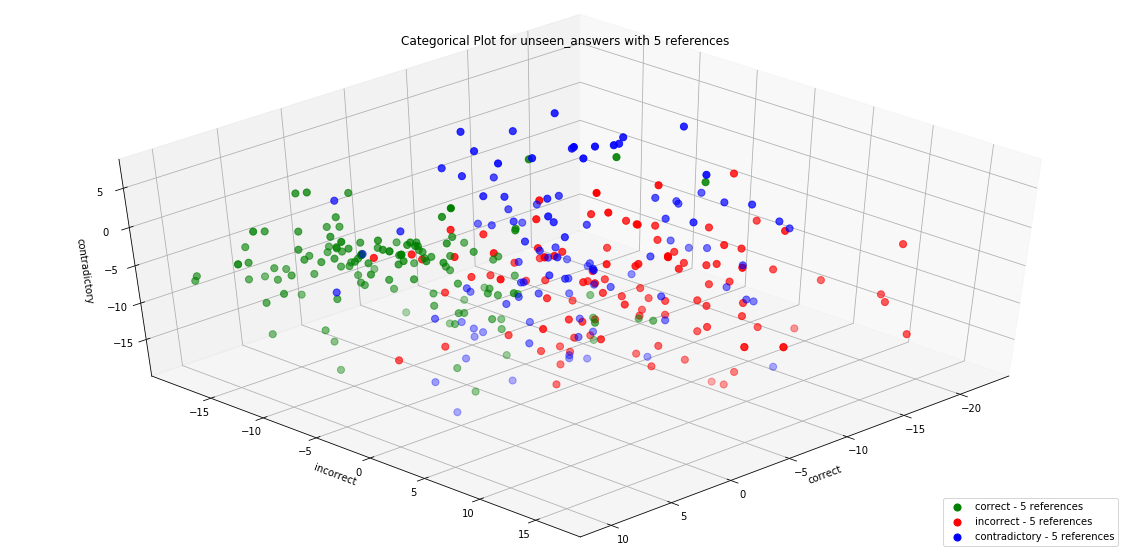

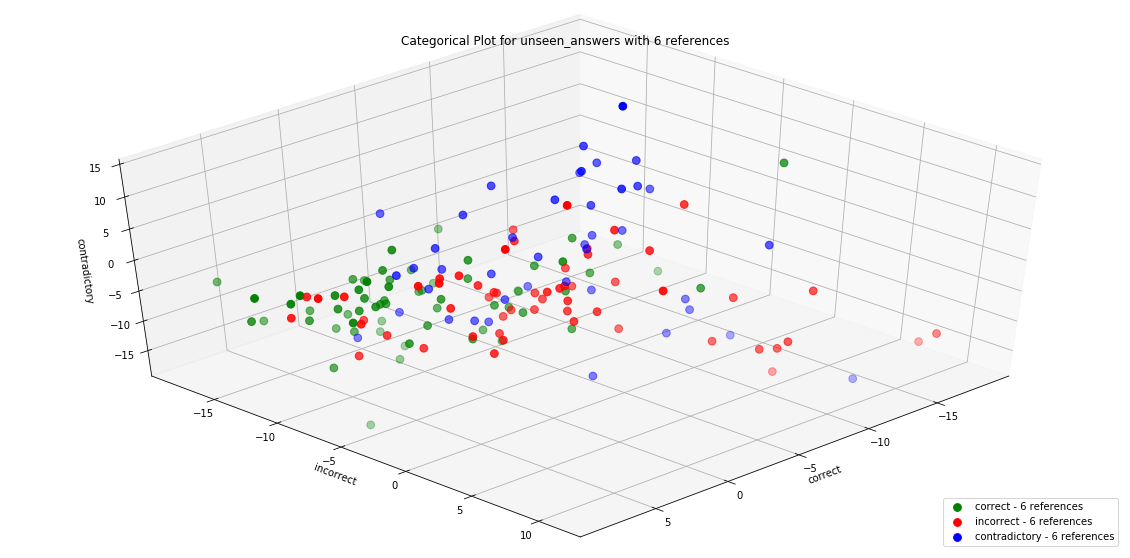

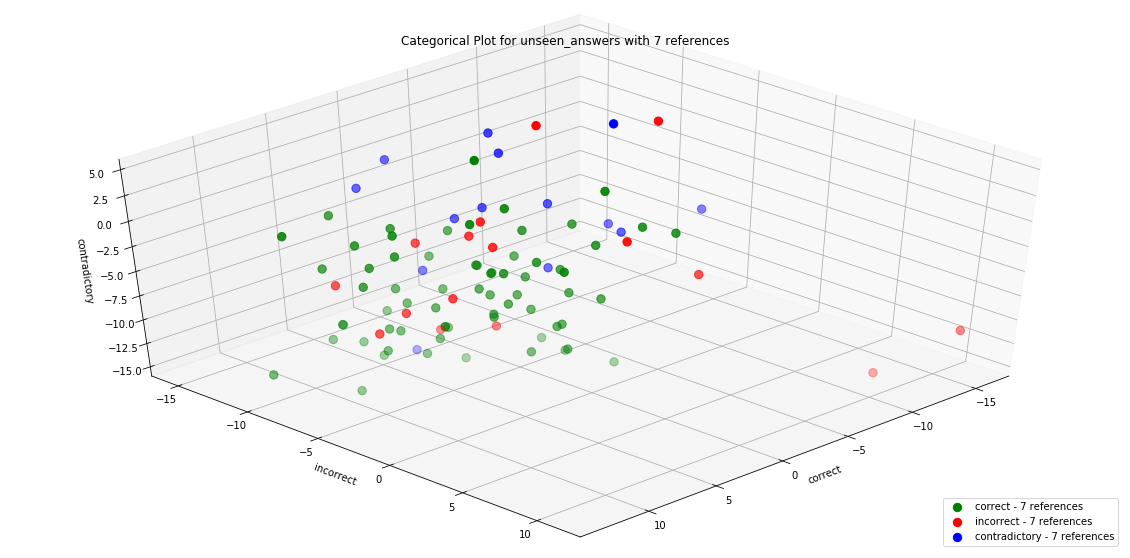

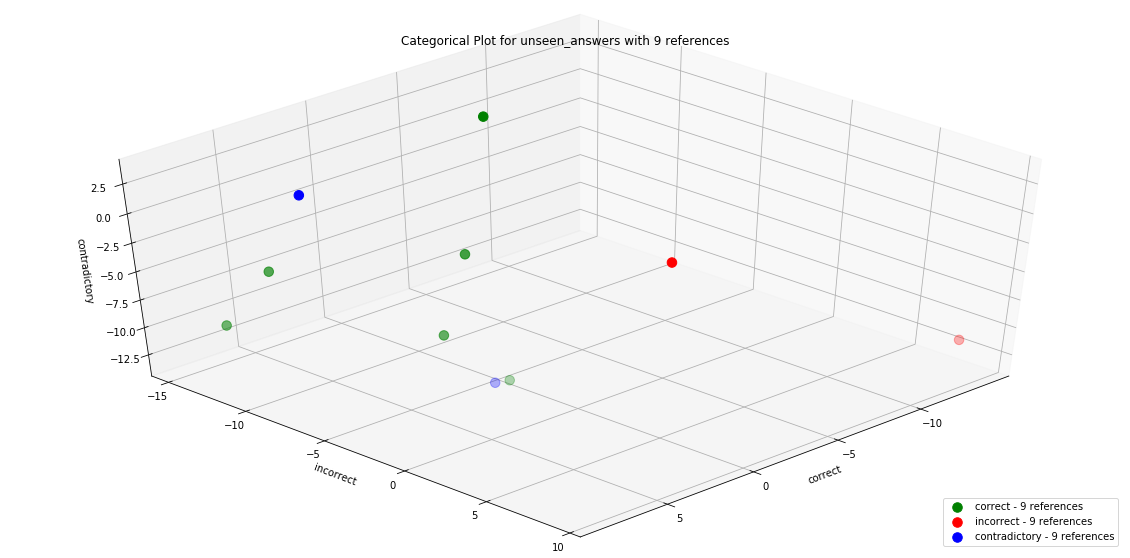

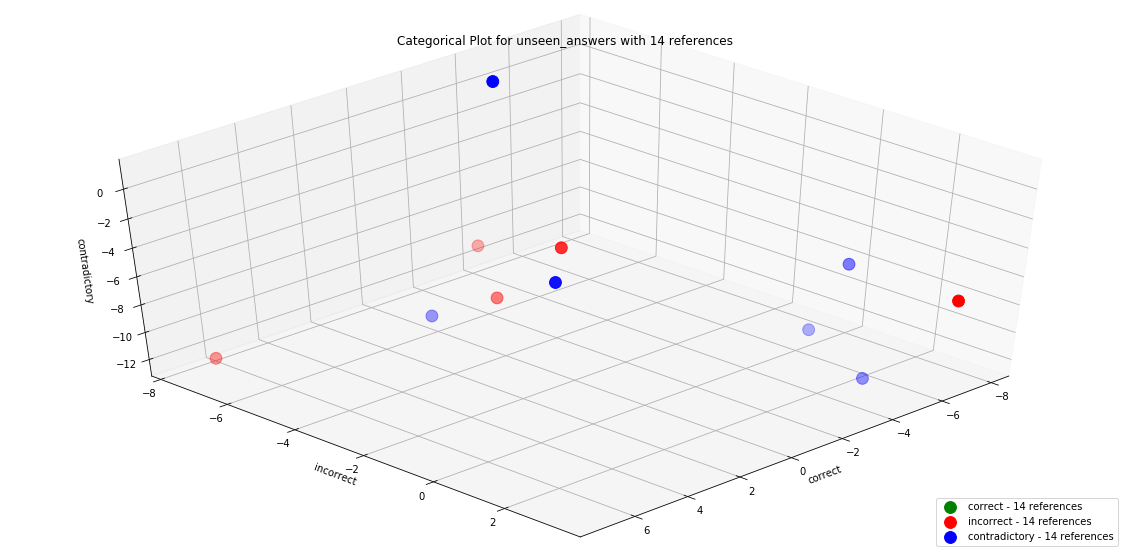

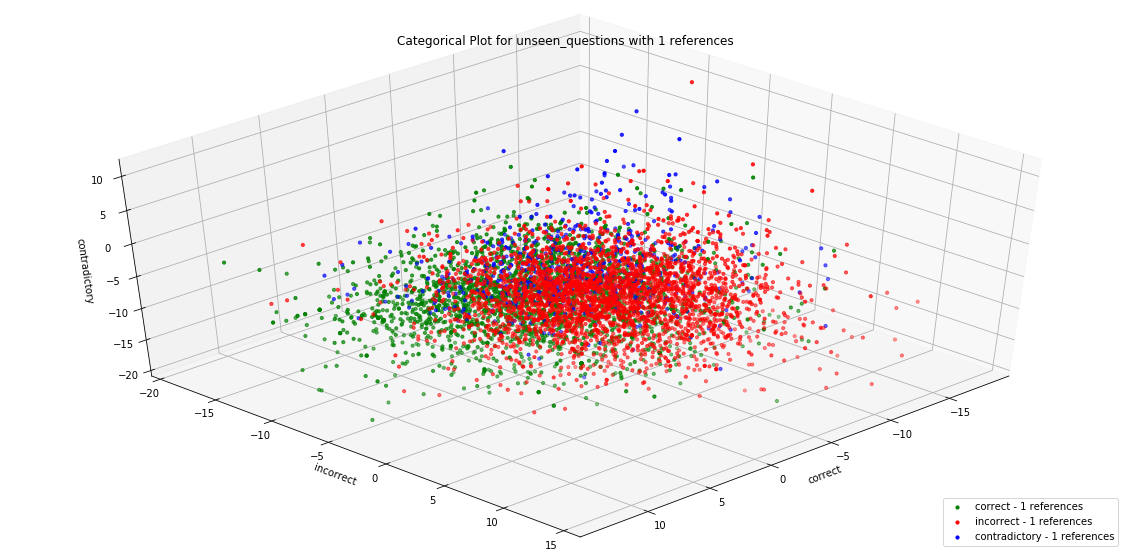

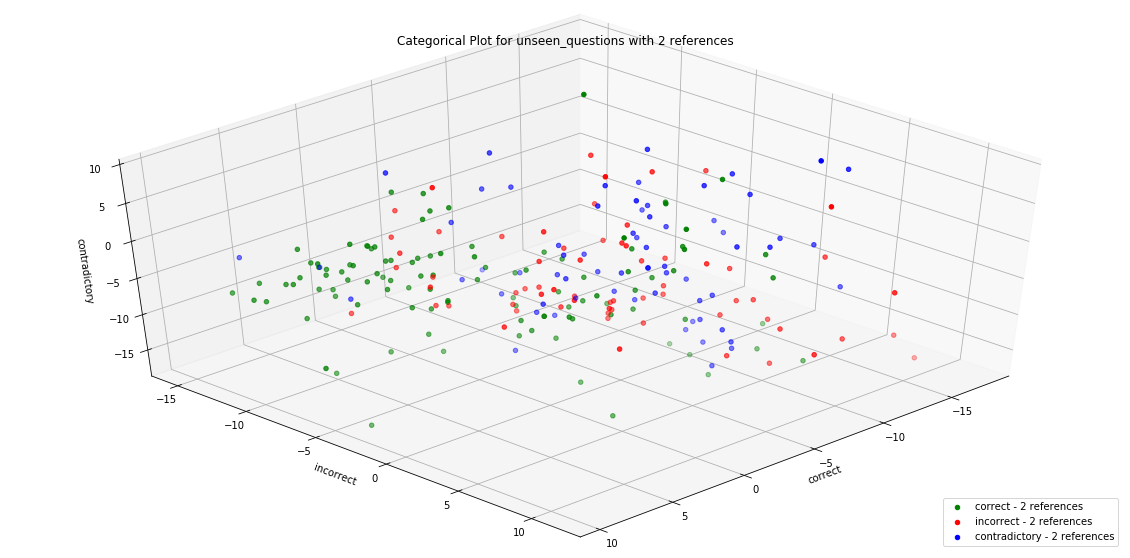

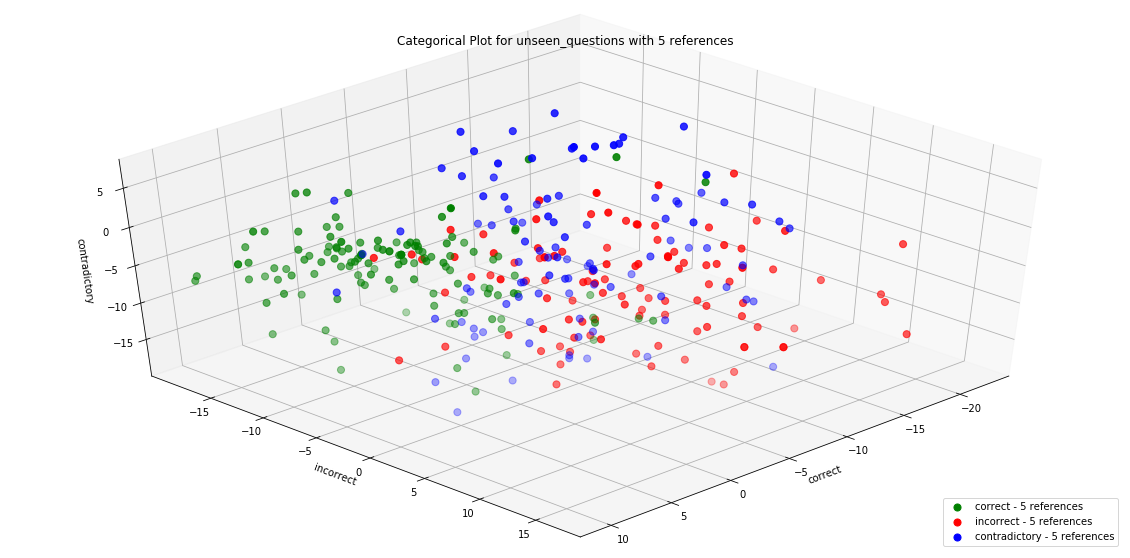

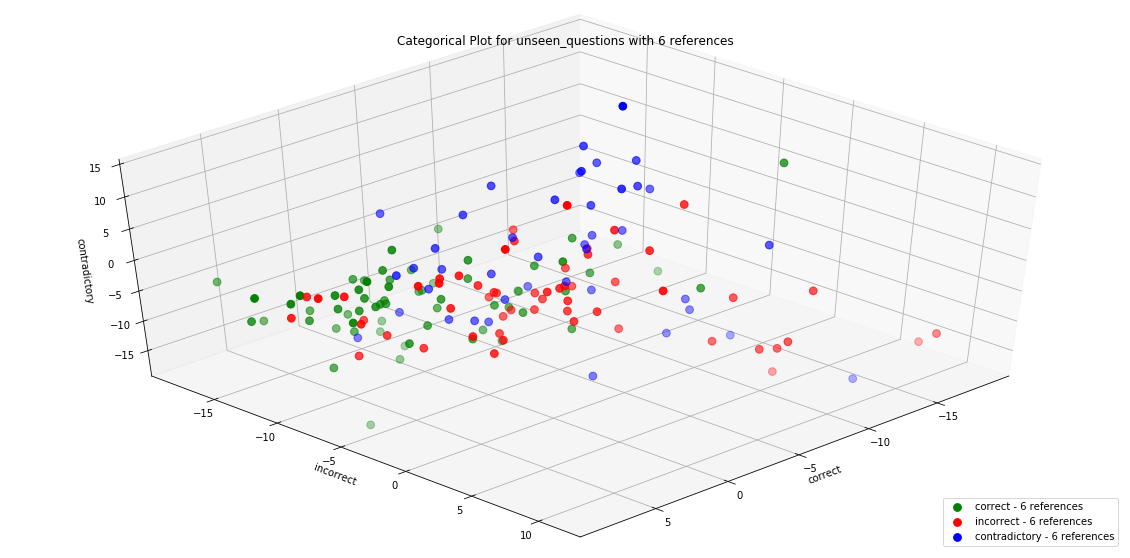

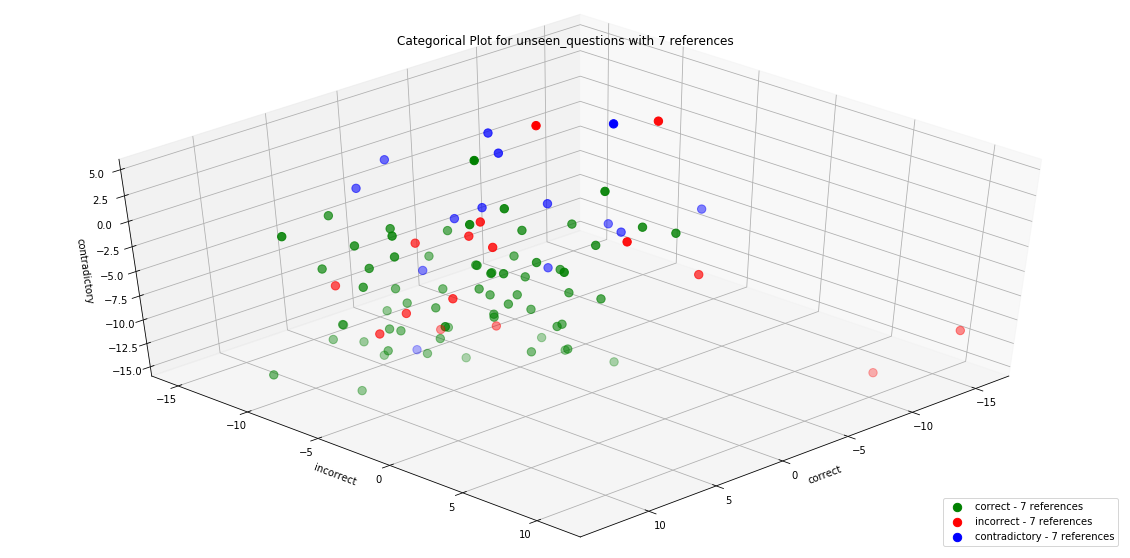

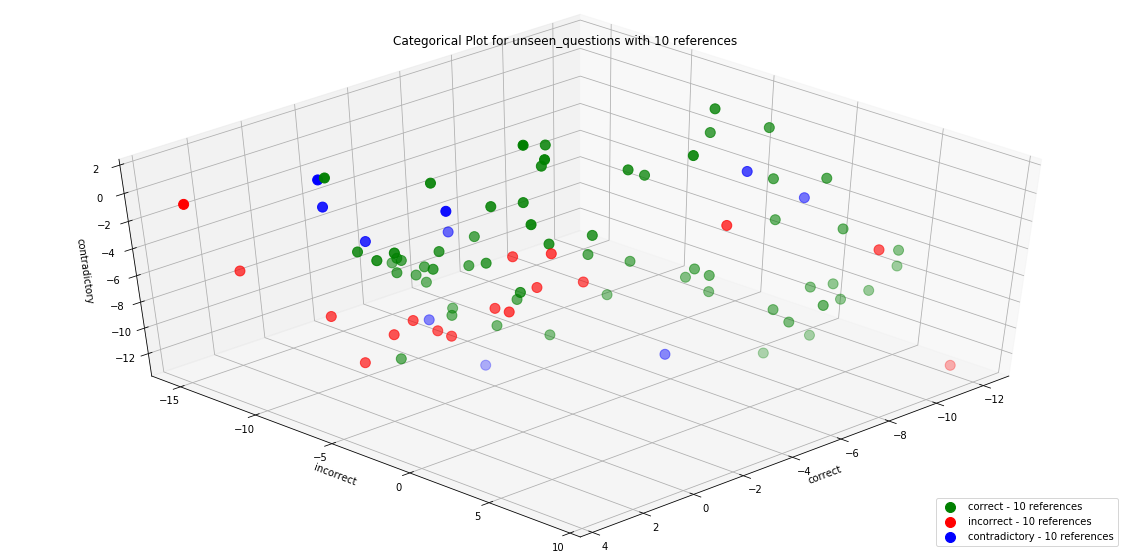

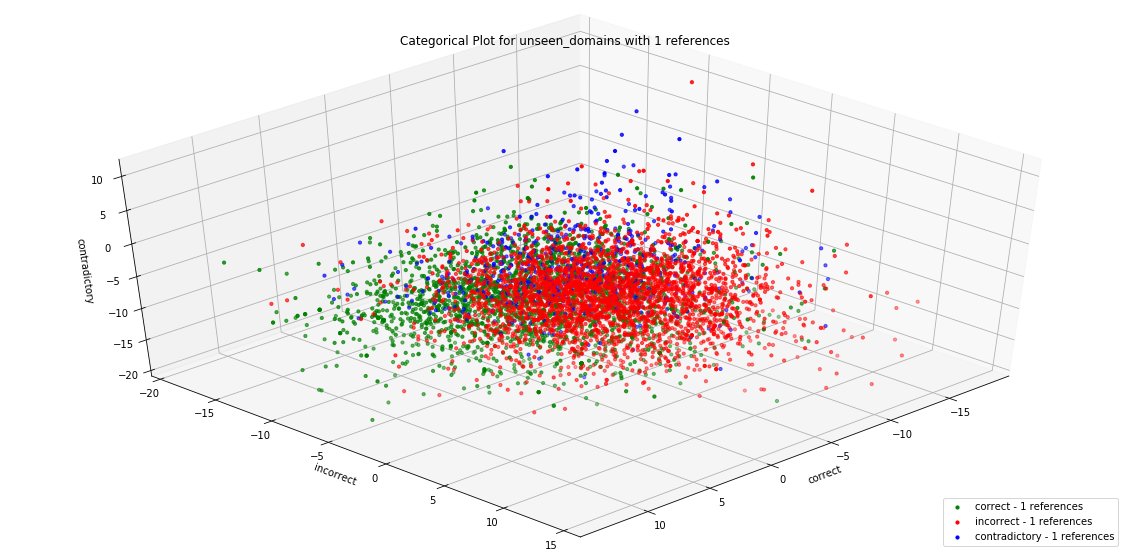

In [19]:
#%matplotlib notebook

for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    reduced = summed_c[summed_c['dataset'] == t].groupby(['references']).count().reset_index()
    
    for count in reduced['references']:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(
            summed[summed['label'] == 2][summed['references'] == count]['correct'],
            summed[summed['label'] == 2][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 2][summed['references'] == count]['contradictory'], 
            c = 'green',
            label = 'correct - %d references' % count,
            s = count * 10
        )
        ax.scatter(
            summed[summed['label'] == 1][summed['references'] == count]['correct'],
            summed[summed['label'] == 1][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 1][summed['references'] == count]['contradictory'], 
            c = 'red',
            label = 'incorrect - %d references' % count,
            s = count * 10
        )
        ax.scatter(
            summed[summed['label'] == 0][summed['references'] == count]['correct'],
            summed[summed['label'] == 0][summed['references'] == count]['incorrect'], 
            summed[summed['label'] == 0][summed['references'] == count]['contradictory'], 
            c = 'blue',
            label = 'contradictory - %d references' % count,
            s = count * 10
        )
        ax.view_init(45, 45)
        ax.set_xlabel('correct')
        ax.set_ylabel('incorrect')
        ax.set_zlabel('contradictory')
        plt.title('Categorical Plot for %s with %d references' % (t, count))
        plt.legend(loc="lower right")
        plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0.98, 'unseen questions')

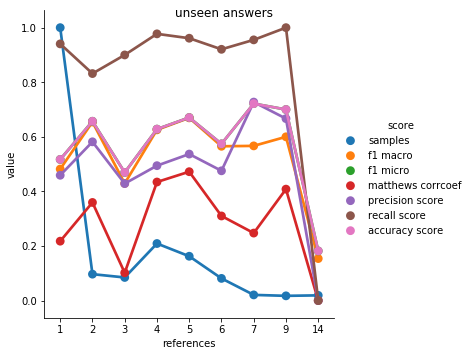

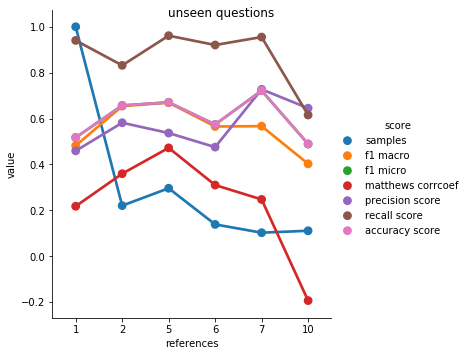

In [20]:
eval_df = pd.DataFrame(columns = [ 
    'score',
    'value', 
    'dataset', 
    'references'
])
eval_df['score'] = eval_df['score'].astype(np.str)
eval_df['value'] = eval_df['value'].astype(np.float)
eval_df['dataset'] = eval_df['dataset'].astype(np.str)
eval_df['references'] = eval_df['references'].astype(np.uint8)


for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    reduced = summed_c[summed_c['dataset'] == t].groupby(['references']).count().reset_index()

    for count, samples in zip(reduced['references'], reduced['dataset']):
        eval_df = eval_df.append({
            'score': 'samples', 
            'value': samples / reduced['dataset'].max(),
            'dataset': t,
            'references': count
        }, ignore_index=True)
    
    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'f1 macro', 
            'value': f1_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1}), average='macro'),
            'dataset': t,
            'references': count
        }, ignore_index=True)
    
    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'f1 micro', 
            'value': f1_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1}), average='micro'),
            'dataset': t,
            'references': count
        }, ignore_index=True)
    
    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'matthews corrcoef', 
            'value': matthews_corrcoef(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'dataset': t,
            'references': count
        }, ignore_index=True)

    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'precision score', 
            'value': precision_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'dataset': t,
            'references': count
        }, ignore_index=True)
    
    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'recall score', 
            'value': recall_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'dataset': t,
            'references': count
        }, ignore_index=True)
    
    for count in reduced['references']:
        eval_df = eval_df.append({
            'score': 'accuracy score', 
            'value': accuracy_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'dataset': t,
            'references': count
        }, ignore_index=True)
        

sns.catplot(
    x = 'references', 
    y = 'value', 
    hue = 'score', 
    kind = 'point', 
    data=eval_df[eval_df['dataset'] == 'unseen_answers']
).fig.suptitle('unseen answers')

sns.catplot(
    x = 'references', 
    y = 'value', 
    hue = 'score', 
    kind = 'point', 
    data=eval_df[eval_df['dataset'] == 'unseen_questions']
).fig.suptitle('unseen questions')

In [21]:
eval_df = pd.DataFrame(columns = [ 
    'dataset', 
    'references',
    'samples',
    'f1 macro',
    'f1 micro',
    'matthews corrcoef',
    'precision score',
    'recall score',
    'accuracy score'
])
eval_df['dataset'] = eval_df['dataset'].astype(np.str)
eval_df['references'] = eval_df['references'].astype(np.int)
eval_df['samples'] = eval_df['samples'].astype(np.int)

eval_df['f1 macro'] = eval_df['f1 macro'].astype(np.float)
eval_df['f1 micro'] = eval_df['f1 micro'].astype(np.float)
eval_df['matthews corrcoef'] = eval_df['matthews corrcoef'].astype(np.float)
eval_df['precision score'] = eval_df['precision score'].astype(np.float)
eval_df['recall score'] = eval_df['recall score'].astype(np.float)
eval_df['accuracy score'] = eval_df['accuracy score'].astype(np.float)


for t in [ 'unseen_answers', 'unseen_questions', 'unseen_domains' ]:
    reduced = summed_c[summed_c['dataset'] == t].groupby(['references']).count().reset_index()

    for count, samples in zip(reduced['references'], reduced['dataset']):
        eval_df = eval_df.append({
            'dataset': t,
            'references': count,
            'samples': samples,
            'f1 macro': f1_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1}), average='macro'),
            'f1 micro': f1_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1}), average='micro'),
            'matthews corrcoef': matthews_corrcoef(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'precision score': precision_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'recall score': recall_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
            'accuracy score': accuracy_score(summed_c[summed['references'] == count]['label'], summed_c[summed['references'] == count][['incorrect', 'correct']].idxmax(axis = 1).replace({'incorrect': 0, 'correct': 1})),
        }, ignore_index=True)

eval_df.to_csv('scores_de.csv')
eval_df

dataset  references  samples  f1 macro  f1 micro  \
0     unseen_answers           1      579  0.481812  0.517080   
1     unseen_answers           2       56  0.654234  0.656904   
2     unseen_answers           3       49  0.429211  0.469388   
3     unseen_answers           4      121  0.625542  0.628099   
4     unseen_answers           5       94  0.669444  0.670588   
5     unseen_answers           6       47  0.565312  0.574074   
6     unseen_answers           7       12  0.566749  0.721649   
7     unseen_answers           9       10  0.600000  0.700000   
8     unseen_answers          14       11  0.153846  0.181818   
9   unseen_questions           1      831  0.481812  0.517080   
10  unseen_questions           2      183  0.654234  0.656904   
11  unseen_questions           5      246  0.669444  0.670588   
12  unseen_questions           6      115  0.565312  0.574074   
13  unseen_questions           7       85  0.566749  0.721649   
14  unseen_questions          10       92  0.402680  0.489130   
15    unseen_domains           1     4562  0.481812  0.517080   

    matthews corrcoef  precision score  recall score  accuracy score  
0            0.217594         0.459091      0.940486        0.517080  
1            0.359437         0.581699      0.831776        0.656904  
2            0.101710         0.428571      0.900000        0.469388  
3            0.434342         0.494253      0.977273        0.628099  
4            0.472170         0.536797      0.961240        0.670588  
5            0.309955         0.475410      0.920635        0.574074  
6            0.247283         0.727273      0.955224        0.721649  
7            0.408248         0.666667      1.000000        0.700000  
8            0.000000         0.000000      0.000000        0.181818  
9            0.217594         0.459091      0.940486        0.517080  
10           0.359437         0.581699      0.831776        0.656904  
11           0.472170         0.536797      0.961240        0.670588  
12           0.309955         0.475410      0.920635        0.574074  
13           0.247283         0.727273      0.955224        0.721649  
14          -0.193719         0.645161      0.615385        0.489130  
15           0.217594         0.459091      0.940486        0.517080